In [408]:
suppressWarnings({
    library(lmerTest)
    library(lme4)
    library(ggplot2)
    library(dplyr)
    library(tidyr)
    library(sjPlot)
    library(IRdisplay)
    library(car)
    library(ggeffects)
    library(gridExtra)
    library(repr)
    
})
options(repr.plot.width=4, repr.plot.height=3)

# Investigating MHWs + Phytoplankton Performance Response via LMMs

Tony Cannistra, May 2020

**Purpose**: To experiment with linear mixed effects models to examine whether a significant relationship exists between latitude, yearly mean sea surface temperature, and performance ratio during marine heatwave events. 

**Method**: Build a linear mixed model of performance ratio with the following effects: 

*Fixed*: 
* Second-degree polynomial of Latitude *(perhaps also abs(lat))*
* mean_sst_event_year_local
* season
* *interaction terms*


*Random*:
* phytoplankton isolate


Perhaps season should be a fixed effect, especially since it likely does have control over the direction + shape of the curve. 

## Data

We compute individual isolate performance for all local heatwaves in [this notebook](../Individual_Isolate_performance.ipynb), and use these data below. 

In [409]:
mhwPerformance <- read.csv("../isolate_performance_withnegative.csv")
mhwPerformance = mhwPerformance %>% mutate(isolate = factor(isolate))
head(mhwPerformance)

X,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_mean,performance_diff_unscaled_mean,...,intensity_mean,duration,start_doy,peak_doy,current_year_sst_mean,start_date,peak_date,perf_det_ratio,latbin,doy_bins
0,-74.875,164.625,1,4,3.433027,1.303966,0.4291283,0.23719293,0.078058928,...,1.2978105,9,1,1,-1.202301,1986-12-31,5.364576e+17,0.8461350,"(-75.026, -59.75]","(0.639, 91.25]"
1,-74.875,164.625,1,5,6.265167,1.269172,0.4176778,0.28725032,0.094532547,...,1.5283193,16,21,32,-1.103370,1987-01-21,5.391360e+17,0.8156109,"(-75.026, -59.75]","(0.639, 91.25]"
2,-74.875,164.625,1,11,9.585366,1.713322,0.5638451,0.03568606,0.011744091,...,0.1877301,18,232,244,-1.168743,1988-08-19,5.889888e+17,0.9795979,"(-75.026, -59.75]","(181.5, 271.75]"
3,-74.875,164.625,1,14,10.139295,1.711648,0.5632942,0.03325621,0.010944441,...,0.1741022,19,196,201,-1.181397,1989-07-15,6.168960e+17,0.9809409,"(-75.026, -59.75]","(181.5, 271.75]"
4,-74.875,164.625,1,37,6.210158,1.715494,0.5645598,0.02973751,0.009786456,...,0.1560303,12,215,220,-1.219370,1995-08-03,8.078400e+17,0.9829606,"(-75.026, -59.75]","(181.5, 271.75]"
5,-74.875,164.625,1,69,5.665564,1.721560,0.5665564,0.02600654,0.008558612,...,0.1353238,11,133,138,-1.088333,2004-05-12,1.084752e+18,0.9851187,"(-75.026, -59.75]","(91.25, 181.5]"


We need to adjust for the effect of hemisphere to "align" seasons and convert to "season" factor variables from "peak_doy" column:

In [410]:
mhwPerformance[between(mhwPerformance$lat, -90, 0), 'peak_doy'] = (mhwPerformance[between(mhwPerformance$lat, -90, 0), 'peak_doy'] - 180) %% 365

In [411]:
mhwPerformance = mhwPerformance %>%  
                    mutate(season = 
                           case_when(
                                (between(peak_doy, 0, 77) | between(peak_doy, 355, 366)) ~ "winter", # January 1 - March XX or December XX - December 31
                                between(peak_doy, 78, 170) ~ "spring", # March XX - June XX
                                between(peak_doy, 171, 295) ~ "summer", # June XX - September XX
                                between(peak_doy, 296, 354) ~ "fall" # September XX - December XX
                        )
                    )

In [412]:
head(mhwPerformance %>% select(peak_doy, season))

peak_doy,season
186,summer
217,summer
64,winter
21,winter
40,winter
323,fall


We'll clean up by dropping NAs and `Inf`s 

We'll also **scale the input variables** for later, but the initial models will use the raw values: 

In [413]:
mhwPerformance = mhwPerformance %>%
    mutate(
        lat_scaled = scale(lat),
        sst_scaled = scale(current_year_sst_mean), 
        abslat_scaled = scale(abs(lat)),
        abslat = abs(lat)
    )

## Models

Let's define the standard model formulations here:

In [414]:
formula <- performance_diff_mean ~ (poly(lat_scaled, 2) + sst_scaled + season)^2
formula_unscaled <- performance_diff_mean ~ (poly(lat, 2) + current_year_sst_mean + season)^2

formula_abslat <- performance_diff_mean ~ (abslat_scaled + sst_scaled + season)^2
formula_abslat_unscaled <- performance_diff_mean ~ (abslat + current_year_sst_mean + season)^2

And the random effects formulations: 

In [415]:
formula_re <- performance_diff_mean ~ (poly(lat_scaled, 2) + sst_scaled + season)^2 + (1|isolate)
formula_unscaled_re <- performance_diff_mean ~ (poly(lat, 2) + current_year_sst_mean + season)^2 + (1|isolate)

formula_abslat_re <- performance_diff_mean ~ (abslat_scaled + sst_scaled + season)^2 + (1|isolate)
formula_abslat_unscaled_re <- performance_diff_mean ~ (abslat + current_year_sst_mean + season)^2 + (1|isolate)

We'll start with a simple linear model with all terms.

In [416]:
simple_lm = lm(formula, data=mhwPerformance)
summary(simple_lm)


Call:
lm(formula = formula, data = mhwPerformance)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.99050 -0.07070  0.00323  0.07108  1.06263 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        0.065888   0.006375  10.336  < 2e-16 ***
poly(lat_scaled, 2)1               3.054584   0.551316   5.541 3.16e-08 ***
poly(lat_scaled, 2)2              -2.225730   1.216945  -1.829  0.06746 .  
sst_scaled                        -0.075876   0.016682  -4.549 5.52e-06 ***
seasonspring                       0.024568   0.007316   3.358  0.00079 ***
seasonsummer                      -0.111431   0.006883 -16.190  < 2e-16 ***
seasonwinter                       0.067969   0.007575   8.973  < 2e-16 ***
poly(lat_scaled, 2)1:sst_scaled    0.292762   0.161607   1.812  0.07011 .  
poly(lat_scaled, 2)2:sst_scaled    0.450125   0.188086   2.393  0.01674 *  
poly(lat_scaled, 2)1:seasonspring -0.075685   0.621921  -0.122  0.903

In [417]:
baseline_hline = geom_hline(yintercept=0, linetype='dashed', color='blue', size=0.6, alpha=0.6)

## Simple Model with Random Effects

Only `isolate` as random effect for now: 

In [418]:
simple_re = lmer(
    formula_re,
    data=mhwPerformance
)
summary(simple_re)


Correlation matrix not shown by default, as p = 18 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: formula_re
   Data: mhwPerformance

REML criterion at convergence: -8033.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.3509 -0.4540 -0.0408  0.5075  5.6512 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.02227  0.1492  
 Residual             0.01191  0.1091  
Number of obs: 5299, groups:  isolate, 75

Fixed effects:
                                    Estimate Std. Error         df t value
(Intercept)                        8.681e-02  2.464e-02  7.525e+01   3.524
poly(lat_scaled, 2)1              -1.859e-01  2.240e+00  7.743e+01  -0.083
poly(lat_scaled, 2)2               1.354e+01  3.060e+00  1.641e+02   4.426
sst_scaled                         1.490e-01  2.666e-02  1.127e+03   5.588
seasonspring                       1.901e-02  4.926e-03  5.204e+03   3.858
seasonsummer                      -1.075e-01  4.643e-03  5.204e+03 -23.156
seasonwi

Model contains splines or polynomial terms. Consider using `terms="lat_scaled [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="sst_scaled [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


Error: Confidence intervals could not be computed.
* Reason: "`season` does not have enough factor levels. Try to remove `[]`."
* Source: .safe_se_from_vcov(model, prediction_data, value_adjustment, terms, model_class, type, vcov.fun, vcov.type, vcov.args, condition, interval)


Model contains splines or polynomial terms. Consider using `terms="season [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


NULL

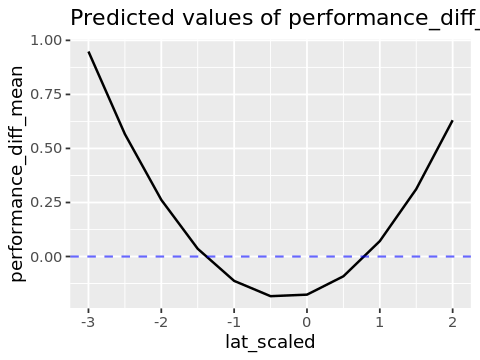

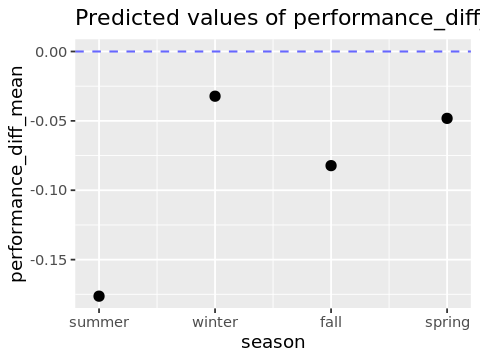

In [419]:
simple_re_plots = plot_model(simple_re, type='pred')
simple_re_plots$lat + baseline_hline
simple_re_plots$current_year_sst_mean + baseline_hline
simple_re_plots$season + baseline_hline

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 9 rows containing missing values (geom_point).”

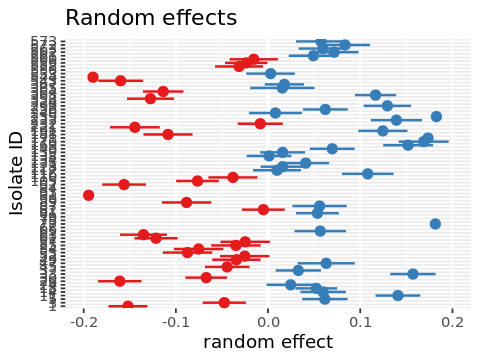

In [420]:
plot_model(simple_re, type='re') +
    xlab("Isolate ID") + 
    ylab('random effect')+
    ylim(-0.2, 0.2)

## More Intense Heatwaves =? Stronger Signal?

There's probably a lot of noise from shorter events here. 

Lets take a look at the distribution of heatwaves by intensity: 

In [421]:
median(mhwPerformance$intensity_mean)

[1] 1.519607

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


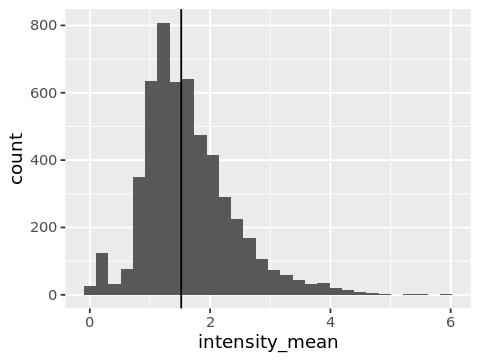

In [422]:
ggplot(mhwPerformance, aes(x=intensity_mean)) +
    geom_histogram() + 
    geom_vline(xintercept=median(mhwPerformance$intensity_mean)) 

We can use ~1.5 C as our threshold (median?)

In [423]:
intensity_threshold = 1.5

In [424]:
intenseMhwPerformance = mhwPerformance %>% filter(intensity_mean > intensity_threshold)

In [425]:
head(intenseMhwPerformance)

X,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_mean,performance_diff_unscaled_mean,...,start_date,peak_date,perf_det_ratio,latbin,doy_bins,season,lat_scaled,sst_scaled,abslat_scaled,abslat
1,-74.875,164.625,1,5,6.2651666,1.26917212,0.41767777,0.28725032,0.09453255,...,1987-01-21,5.391360e+17,8.156109e-01,"(-75.026, -59.75]","(0.639, 91.25]",summer,-2.537581,-2.432479754,2.40863645,74.875
19,-57.875,139.875,558,6,0.8048469,0.14412670,0.04734394,-0.14278485,-0.04690315,...,1985-01-03,4.737312e+17,3.234330e+04,"(-59.75, -44.625]","(0.639, 91.25]",summer,-2.047310,-2.012213646,1.43853309,57.875
27,-41.375,174.875,18,30,1.2221654,0.09605062,0.02909918,0.07816765,0.02368141,...,1999-02-08,9.217152e+17,5.517525e-01,"(-44.625, -29.5]","(0.639, 91.25]",summer,-1.571460,-0.494669663,0.49696219,41.375
34,-36.125,174.875,573,53,1.7526555,0.07958929,0.04736907,0.13657643,0.08128604,...,2017-11-28,1.512950e+18,3.521463e-01,"(-44.625, -29.5]","(0.639, 91.25]",spring,-1.420053,-0.148946286,0.19737144,36.125
37,-34.375,17.125,26,42,0.2014159,0.08242058,0.03356932,-0.07164985,-0.02918248,...,2005-07-15,1.121558e+18,7.700049e+00,"(-44.625, -29.5]","(181.5, 271.75]",winter,-1.369584,-0.077268109,0.09750786,34.375
38,-34.375,17.125,26,45,4.8919199,0.48043255,0.19567680,-0.21742883,-0.08855723,...,2007-03-01,1.174262e+18,1.827904e+00,"(-44.625, -29.5]","(0.639, 91.25]",summer,-1.369584,-0.003833995,0.09750786,34.375


In [426]:
nrow(intenseMhwPerformance)

[1] 2721

**Simple Model**

In [427]:
simple_intense_lm = lm(
    formula,
    data=intenseMhwPerformance)
summary(simple_intense_lm)


Call:
lm(formula = formula, data = intenseMhwPerformance)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.90588 -0.07210  0.00696  0.08259  0.97942 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        0.102665   0.009973  10.295  < 2e-16 ***
poly(lat_scaled, 2)1               1.800950   0.574036   3.137  0.00172 ** 
poly(lat_scaled, 2)2              -0.271012   0.963271  -0.281  0.77847    
sst_scaled                        -0.031023   0.025489  -1.217  0.22366    
seasonspring                       0.003394   0.011878   0.286  0.77512    
seasonsummer                      -0.176645   0.011126 -15.877  < 2e-16 ***
seasonwinter                       0.093073   0.012956   7.184 8.71e-13 ***
poly(lat_scaled, 2)1:sst_scaled    1.127001   0.230970   4.879 1.13e-06 ***
poly(lat_scaled, 2)2:sst_scaled    0.757743   0.196717   3.852  0.00012 ***
poly(lat_scaled, 2)1:seasonspring -0.882607   0.708212  -1.246

**Simple Random Effects**

In [428]:
simple_intense_re = lmer(
    formula_re, 
    data=intenseMhwPerformance
)
summary(simple_intense_re)


Correlation matrix not shown by default, as p = 18 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: formula_re
   Data: intenseMhwPerformance

REML criterion at convergence: -3413.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.7477 -0.4897 -0.0002  0.4773  4.3940 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.02358  0.1535  
 Residual             0.01503  0.1226  
Number of obs: 2721, groups:  isolate, 69

Fixed effects:
                                    Estimate Std. Error         df t value
(Intercept)                        1.112e-01  2.471e-02  6.138e+01   4.500
poly(lat_scaled, 2)1               3.609e+00  1.088e+00  8.309e+01   3.319
poly(lat_scaled, 2)2               5.799e+00  1.617e+00  1.515e+02   3.586
sst_scaled                         1.566e-01  3.391e-02  9.335e+02   4.619
seasonspring                       3.606e-03  8.269e-03  2.649e+03   0.436
seasonsummer                      -1.795e-01  7.718e-03  2.645e+03 -23.263
s

## Absolute Latitude instead of Poly(2)

In [429]:
abslat_re = lmer(
    formula_abslat_re, 
    data=mhwPerformance
)
summary(abslat_re)


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: formula_abslat_re
   Data: mhwPerformance

REML criterion at convergence: -8263.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.1260 -0.4422 -0.0368  0.4987  5.5567 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.02216  0.1489  
 Residual             0.01129  0.1062  
Number of obs: 5299, groups:  isolate, 75

Fixed effects:
                             Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                 5.681e-02  2.149e-02  7.546e+01   2.644  0.00996
abslat_scaled               2.170e-01  2.764e-02  2.063e+02   7.850 2.23e-13
sst_scaled                  2.075e-01  2.418e-02  1.520e+03   8.582  < 2e-16
seasonspring                2.012e-02  4.778e-03  5.207e+03   4.211 2.58e-05
seasonsummer               -1.069e-01  4.501e-03  5.207e+03 -23.751  < 2e-16
seasonwinter                6.339e-02  4.931e-03  5.205e+03  12.

In [430]:
abslat_intense_re = lmer(
   formula_abslat_re,
    data=intenseMhwPerformance, 
)
summary(abslat_intense_re)


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: formula_abslat_re
   Data: intenseMhwPerformance

REML criterion at convergence: -3447.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.7183 -0.4896  0.0274  0.4982  4.3528 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.02446  0.1564  
 Residual             0.01459  0.1208  
Number of obs: 2721, groups:  isolate, 69

Fixed effects:
                             Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                 8.299e-02  2.415e-02  6.571e+01   3.437  0.00102
abslat_scaled               2.063e-01  3.473e-02  1.992e+02   5.940 1.25e-08
sst_scaled                  1.860e-01  3.265e-02  8.432e+02   5.697 1.68e-08
seasonspring                7.445e-03  8.217e-03  2.661e+03   0.906  0.36499
seasonsummer               -1.641e-01  7.716e-03  2.657e+03 -21.266  < 2e-16
seasonwinter                9.249e-02  8.858e-03  2.652e+

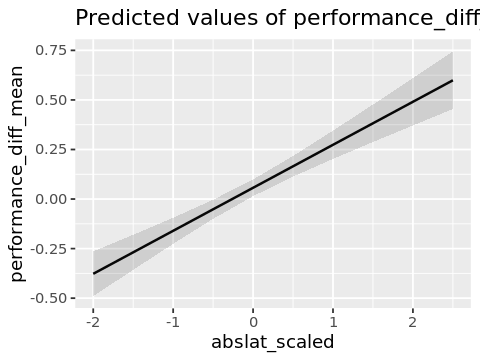

$abslat_scaled

$sst_scaled

$season


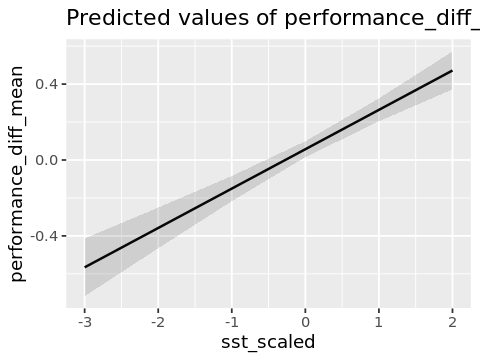

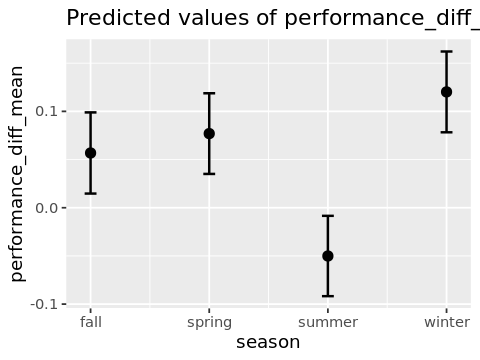

In [431]:
plot_model(abslat_re, type='pred')

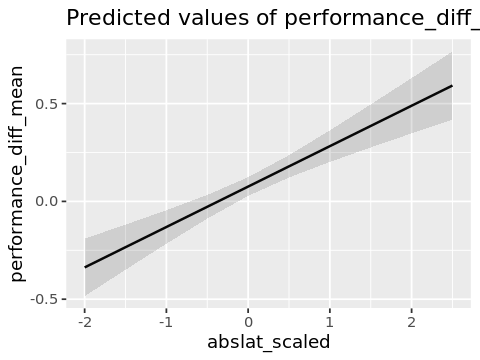

$abslat_scaled

$sst_scaled

$season


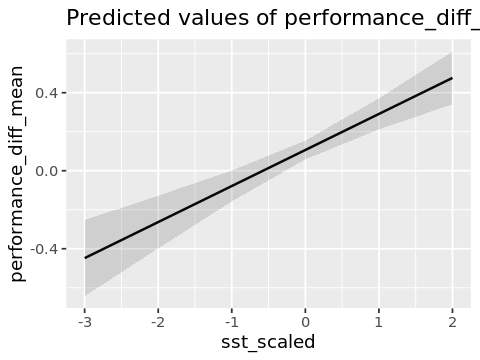

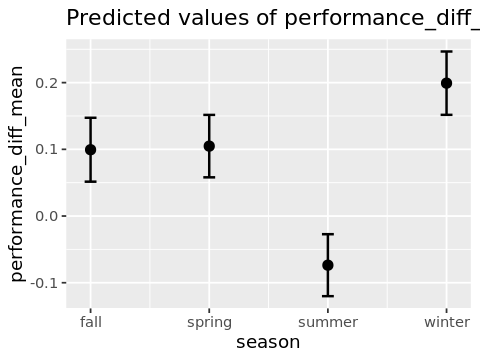

In [432]:
plot_model(abslat_intense_re, type='pred')

## Produce Plots

### Absolute Latitude

**Coefficient Plots, Simple and Intense**

In [447]:
png("./abslat_compare_coefs_diff.png", width=1440, height=950, res=180)
y_limit = ylim(-1, 1)
simple_coefs = plot_model(abslat_re, ci.lvl=NA,  show.values = TRUE, value.offset=.4) + y_limit + ggtitle("A) All MHWs")
intense_coefs = plot_model(abslat_intense_re,show.values = TRUE, value.offset=.4, ci.lvl=NA)+ y_limit + theme(axis.text.y = element_blank()) + ggtitle("B) Intense MHWs")
grid.arrange(simple_coefs, intense_coefs, nrow=1, widths=c(1.7, 1) )
dev.off()

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


png 
  2

**Coefficient Table**

In [448]:
tab_model(
    abslat_re, abslat_intense_re,
    show.stat=TRUE, use.viewer=FALSE, 
    dv.labels=c("Performance Difference [all events]", "Performance Difference [intense events]"), 
    file = "abslat_coef_compare_table.html"
)

**Predictions, All MHW**

In [449]:
png("./abslat_preds_preddiff.png", width=1440, height=700, res=180)

y_limit = ylim(-1, 1)

seas = plot(ggeffect(abslat_re, terms='season')) + 
    baseline_hline + 
    xlab("Season") +
    ylab("Performance Difference")  +
    ggtitle("A) Season") + 
    y_limit


seaslat = plot(ggeffect(abslat_re, terms=c('abslat_scaled', 'season [summer, winter]'))) +
    baseline_hline +
    xlab("Absolute Latitude [scaled]") +
    ylab("Performance Difference")  +
    ggtitle("B) Latitude") + 
    y_limit

    

grid.arrange(seas, seaslat, nrow=1, widths=c(1,1.3))
dev.off()
# seaslat

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


png 
  2

**Predictions, Intense MHW**

In [450]:
png("./abslat_preds_intense_preddiff.png", width=1440, height=700, res=180)

y_limit = ylim(-1, 1)

seas = plot(ggeffect(abslat_intense_re, terms='season')) + 
    baseline_hline + 
    xlab("Season") +
    ylab("Performance Difference")  +
    ggtitle("A) Season") + 
    y_limit


seaslat = plot(ggeffect(abslat_intense_re, terms=c('abslat_scaled', 'season [summer, winter]'))) +
    baseline_hline +
    xlab("Absolute Latitude [scaled]") +
    ylab("Performance Difference")  +
    ggtitle("B) Latitude") + 
    y_limit

    

grid.arrange(seas, seaslat, nrow=1, widths=c(1,1.3))
dev.off()
# seaslat

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


png 
  2

### Regular Latitude

**Coefficients**

In [437]:
png("./polylat_compare_coefs_diff.png", width=1440, height=950, res=180)
y_limit = ylim(-5.5,5.5)
simple_coefs = plot_model(simple_re, ci.lvl=NA,  show.values = TRUE, value.offset=.4) + y_limit + ggtitle("A) All MHWs")
intense_coefs = plot_model(simple_intense_re,show.values = TRUE, value.offset=.4, ci.lvl=NA)+ y_limit + theme(axis.text.y = element_blank()) + ggtitle("B) Intense MHWs")
grid.arrange(simple_coefs, intense_coefs, nrow=1, widths=c(2, 1) )
dev.off()

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Warning message:
“Removed 1 rows containing missing values (geom_text).”

png 
  2

**Coefficients Table**

In [438]:
tab_model(
    simple_re, simple_intense_re,
    show.stat=TRUE, use.viewer=FALSE, 
    dv.labels=c("Performance Difference [all events]", "Performance Difference [intense events]"), 
    file = "polylat_coef_compare_table.html"
)

**Predictions, all MHW**

In [446]:
png("./polylat_preds_preddiff.png", width=1440, height=700, res=180)

 y_limit = ylim(-1, 1)

seas = plot(ggeffect(simple_re, terms='season')) + 
    baseline_hline + 
    xlab("Season") +
    ylab("Performance Difference")  +
    ggtitle("A) Season") + 
    y_limit


seaslat = plot(ggeffect(simple_re, terms=c('lat_scaled', 'season [summer, winter]'))) +
    baseline_hline +
    xlab("Latitude [scaled]") +
    ylab("Performance Difference")  +
    ggtitle("B) Latitude") + 
    y_limit
    

grid.arrange(seas, seaslat, nrow=1, widths=c(1,1.3))
dev.off()
# seaslat

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 2 row(s) containing missing values (geom_path).”

png 
  2

**Predictions, Intense MHW**

In [440]:
png("./polylat_preds_intense_preddiff.png", width=1440, height=700, res=180)

seas = plot(ggeffect(simple_intense_re, terms='season')) + 
    baseline_hline + 
    xlab("Season") +
    ylab("Performance Difference")  +
    ggtitle("A) Season") + 
    ylim(-0.5, 0.5)



seaslat = plot(ggeffect(simple_intense_re, terms=c('lat_scaled', 'season [summer, winter]'))) +
    baseline_hline +
    xlab("Latitude [scaled]") +
    ylab("Performance Difference")  +
    ggtitle("B) Latitude") + 
    ylim(-0.5, 0.5)

    

grid.arrange(seas, seaslat, nrow=1, widths=c(1,1.3))
dev.off()
# seaslat

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Warning message:
“Removed 5 row(s) containing missing values (geom_path).”

png 
  2

## Individual Models per Season

In [453]:
winter_only = mhwPerformance %>% filter(season == "winter")
winter_re = lmer(performance_diff_mean ~ (abslat + sst_scaled)^2 + (1 | isolate), data=winter_only, )

In [454]:
summary(winter_re)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_diff_mean ~ (abslat + sst_scaled)^2 + (1 | isolate)
   Data: winter_only

REML criterion at convergence: -3908.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.8243 -0.3722  0.0080  0.3138  5.2430 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.021913 0.14803 
 Residual             0.001287 0.03588 
Number of obs: 1141, groups:  isolate, 75

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)       -8.181e-04  4.816e-02  1.777e+02  -0.017 0.986466    
abslat             5.187e-03  1.407e-03  1.697e+02   3.687 0.000306 ***
sst_scaled        -4.865e-02  3.358e-02  3.815e+02  -1.449 0.148191    
abslat:sst_scaled  2.736e-03  7.421e-04  1.272e+02   3.687 0.000335 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) abslat

In [452]:
summer_only = mhwPerformance %>% filter(season == "summer")
summer_re = lmer(performance_diff_mean ~ (abslat + sst_scaled)^2 + (1 | isolate), data=summer_only, )
summary(summer_re)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_diff_mean ~ (abslat + sst_scaled)^2 + (1 | isolate)
   Data: summer_only

REML criterion at convergence: -4375.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.0612 -0.3711 -0.0288  0.3465  6.4595 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.032416 0.18004 
 Residual             0.005367 0.07326 
Number of obs: 2003, groups:  isolate, 75

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)       -1.818e-01  5.825e-02  1.716e+02  -3.121  0.00212 **
abslat             3.439e-03  1.692e-03  1.675e+02   2.033  0.04362 * 
sst_scaled         1.080e-01  4.239e-02  2.940e+02   2.548  0.01133 * 
abslat:sst_scaled -2.160e-03  9.399e-04  1.075e+02  -2.298  0.02349 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) abslat sst_

In [451]:
spring_only = mhwPerformance %>% filter(season == "spring")
spring_re = lmer(performance_diff_mean ~ (abslat + sst_scaled)^2 + (1 | isolate), data=spring_only, )
summary(spring_re)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_diff_mean ~ (abslat + sst_scaled)^2 + (1 | isolate)
   Data: spring_only

REML criterion at convergence: -2613.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.3284 -0.2555  0.0049  0.2718  6.8615 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.018823 0.1372  
 Residual             0.006773 0.0823  
Number of obs: 1363, groups:  isolate, 75

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)       -2.208e-02  6.034e-02  1.766e+02  -0.366   0.7149  
abslat             3.918e-03  1.734e-03  1.652e+02   2.259   0.0252 *
sst_scaled        -1.478e-02  4.590e-02  2.218e+02  -0.322   0.7478  
abslat:sst_scaled  1.244e-03  7.886e-04  9.408e+01   1.577   0.1182  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) abslat sst_sc
ab

In [461]:
fall_only = mhwPerformance %>% filter(season == "fall")
fall_re = lmer(performance_diff_mean ~ (abslat + sst_scaled)^2 + (1 | isolate), data=fall_only, )
summary(fall_re)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_diff_mean ~ (abslat + sst_scaled)^2 + (1 | isolate)
   Data: fall_only

REML criterion at convergence: -2220.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.8919 -0.3296  0.0008  0.3554  5.4018 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.016241 0.12744 
 Residual             0.002272 0.04767 
Number of obs: 792, groups:  isolate, 75

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)  
(Intercept)       -2.539e-02  5.468e-02  1.862e+02  -0.464   0.6430  
abslat             3.258e-03  1.577e-03  1.740e+02   2.066   0.0403 *
sst_scaled        -2.935e-02  4.141e-02  2.373e+02  -0.709   0.4792  
abslat:sst_scaled  1.216e-03  7.236e-04  9.740e+01   1.680   0.0962 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) abslat sst_sc
absla

In [463]:
tab_model(
    winter_re,
    spring_re,
    summer_re,
    fall_re,  
    show.stat=TRUE,
    use.viewer=FALSE, 
    dv.labels=c("Winter Only", "Spring Only", "Summer Only", "Autumn Only"), 
    file = "compare_season_models.html"
)